# <font color="yellow"> Statements Integration
This sample showcases the seamless integration of bank statements from an ERP to Kyriba. <br>
The following steps are simulated:
*   Receipt of bank statements for different accounts in different formats (MT940 and CAMT53).
*   Dispatch of Webhook notifications once bank statements are integrated.

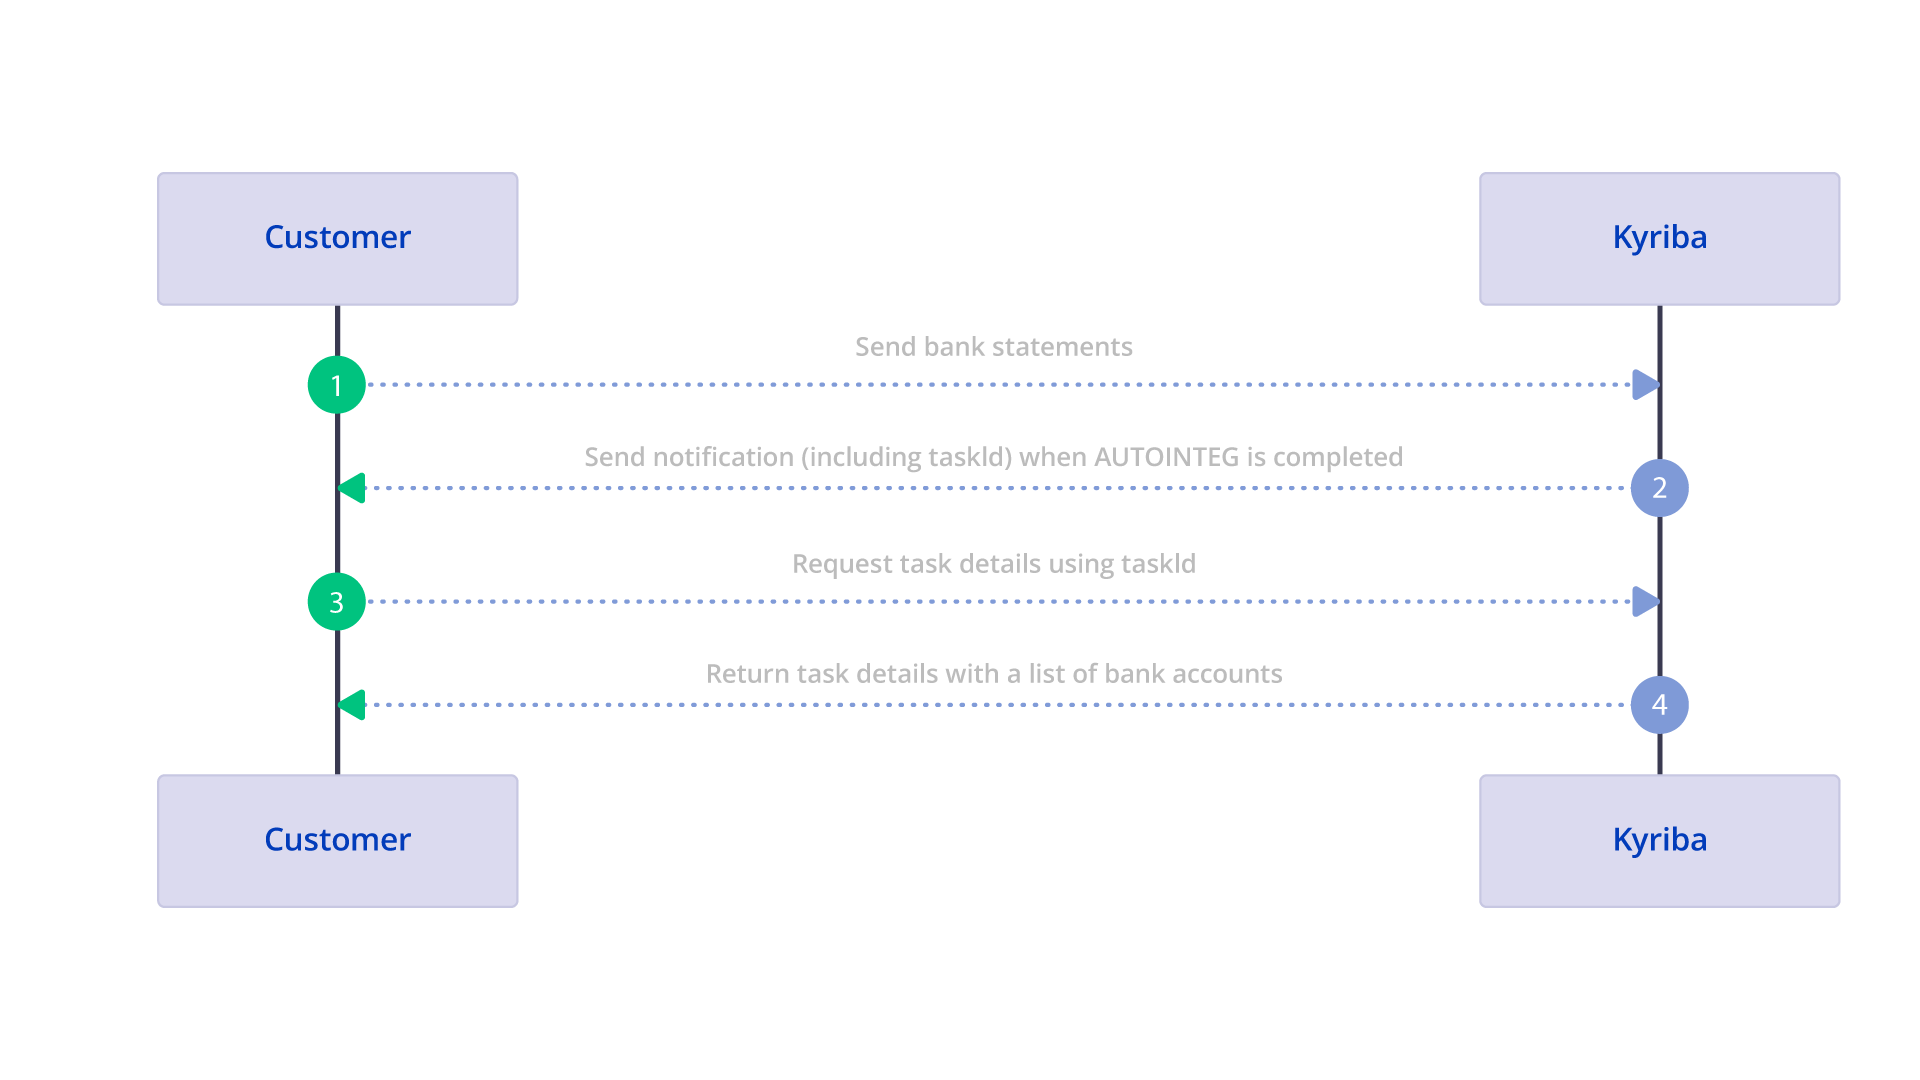

## <font color='yellow'>Step 0.1: Code for token generation and API management</font>

In [ ]:
#@title Select **servicePack** the Sample should run
from subprocess import getstatusoutput
servicePack = "DEMO"

if servicePack == 'DEMO':
  branch = 'main'
else:
  branch = servicePack
print(branch)
rm = getstatusoutput("rm Colab_shared_code_for_API_usage -rf ")
clone = getstatusoutput("git clone -l -s --branch " +  branch + " https://github.com/kyriba/Colab_shared_code_for_API_usage.git")
import importlib
enableFormatterDF = True #@param {type:"boolean"}
from google.colab import data_table
if enableFormatterDF is True:
  data_table.enable_dataframe_formatter()
else:
  data_table.disable_dataframe_formatter()
try:
  importlib.reload(sample_requests)
except:
  print()
from Colab_shared_code_for_API_usage import sample_requests

In [ ]:
#@title Import custom modules
import json as js
import base64
import time
import pandas as pd
from datetime import datetime, date

## <font color='yellow'>Step 0.2: Connect and  retrieve token</font>

In [ ]:
#@title Connect and get token { display-mode: "form" }
token = sample_requests.login()


## <font color='yellow'>Step 1: Generate bank statements and send to Kyriba</font>

## <font color='yellow'>Step 1.1: Generate and import an MT940 </font>

In [ ]:
#@title <font color='lime'> Generate MT940 <font>
from datetime import date, datetime, timedelta
import re

mt_accounts = ['MT940_ACC1', 'MT940_ACC2', 'MT940_ACC3']
now = datetime.now()
statement_date = now.strftime("%Y-%m-%d")
now_time = datetime.now().strftime("%H%M%S")
amount = 100.00

mt940 = ''

for account in mt_accounts:

  #tags 20, 25, 28C
  mt940 += ':20:COMPANY-DEMO\n'
  mt940 += ':25:' + account + '\n'
  mt940 += ':28C:' + statement_date.replace('-', '') + '/' + now_time + '\n'

  request = '/v1/bank-balances/accounts/' + account + '/balances?date=' + statement_date + '&type=END_OF_DAY'
  res_balances = js.loads(sample_requests.get_results(token, request))

  #tag60F
  tmp_string = ''

  if res_balances['bankBalance']['amount'] >= 0:
    tmp_string += 'C'
  else:
    tmp_string += 'D'

  tmp_string += datetime.strptime(statement_date, '%Y-%m-%d').strftime('%y%m%d')
  tmp_string += res_balances['bankBalance']['currencyCode']
  tmp_string += '{:.2f}'.format(res_balances['bankBalance']['amount']).replace('-','').replace('.',',')

  mt940 += ':60F:' + tmp_string + '\n'

  #tags 61, 86
  new_balance = res_balances['bankBalance']['amount']
  for cf in ['C', 'D']:
    tag61 = ''
    tag86 = ''

    tag61 += datetime.strptime(statement_date, '%Y-%m-%d').strftime('%y%m%d')
    tag61 += datetime.strptime(statement_date, '%Y-%m-%d').strftime('%m%d')

    if cf == 'D':
      tag61 += 'D'
    elif cf == 'C':
      tag61 += 'C'

    amount += 1
    new_balance += amount
    tag61 += '{:.2f}'.format(amount).replace('.', ',')

    tag61 += 'APIC'
    tag61 +=  'BR_' + now_time + '_' + str(amount)+ '//' + now_time

    tag86 += 'Bank Reporting use case'

    mt940 += ':61:' + tag61 + '\n'
    mt940 += ':86:' + tag86 + '\n'

  #tag 62F
  tmp_string = ''

  if new_balance >= 0:
    tmp_string += 'C'
  else:
    tmp_string += 'D'

  tmp_string += datetime.strptime(statement_date, '%Y-%m-%d').strftime('%y%m%d')
  tmp_string += res_balances['bankBalance']['currencyCode']
  tmp_string += '{:.2f}'.format(new_balance).replace('-','').replace('.',',')

  mt940 += ':62F:' + tmp_string + '\n\n'


mt940


In [ ]:
#@title <font color='lime'> Import MT940 <font>

res = sample_requests.import_data(token, mt940, 'API_MT940_' + now.strftime("%d%m%Y_%H%M%S") + '.xml', 'IMP_BK_MT940', True, True)


## <font color='yellow'>Step 1.2: Generate and import a CAMT53 </font>

In [ ]:
#@title <font color='lime'> CAMT53 template <font>

camt53 = '''<?xml version="1.0" encoding="UTF-8"?>
<Document xsi:schemaLocation="urn:iso:std:iso:20022:tech:xsd:camt.053.001.04 camt.053.001.04.xsd"
	xmlns="urn:iso:std:iso:20022:tech:xsd:camt.053.001.04"
	xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance">
	<BkToCstmrStmt>
		<GrpHdr>
			<MsgId>602577997205112</MsgId>
			<CreDtTm>2022-03-18T21:15:02</CreDtTm>
			<MsgRcpt>
				<Id>
					<OrgId>
						<AnyBIC>INTRUS33XXX</AnyBIC>
					</OrgId>
				</Id>
			</MsgRcpt>
			<MsgPgntn>
				<PgNb>1</PgNb>
				<LastPgInd>true</LastPgInd>
			</MsgPgntn>
		</GrpHdr>
	</BkToCstmrStmt>
</Document>
'''

tagStmt = '''
	<Stmt>
			<Id>402077308205112</Id>
			<ElctrncSeqNb>1</ElctrncSeqNb>
			<CreDtTm>2022-03-18T21:15:02</CreDtTm>
			<Acct>
				<Id>
					<Othr>
						<Id>FR3409876098551233456781722</Id>
					</Othr>
				</Id>
				<Ccy>EUR</Ccy>
				<Ownr>
					<Nm>Kyriba</Nm>
				</Ownr>
			</Acct>
			<Bal>
				<Tp>
					<CdOrPrtry>
						<Cd>OPBD</Cd>
					</CdOrPrtry>
				</Tp>
				<Amt Ccy="EUR">2695993.91</Amt>
				<CdtDbtInd>CRDT</CdtDbtInd>
				<Dt>
					<Dt>2022-03-18</Dt>
				</Dt>
			</Bal>
			<Bal>
				<Tp>
					<CdOrPrtry>
						<Cd>CLBD</Cd>
					</CdOrPrtry>
				</Tp>
				<Amt Ccy="EUR">1247358.85</Amt>
				<CdtDbtInd>CRDT</CdtDbtInd>
				<Dt>
					<Dt>2022-03-18</Dt>
				</Dt>
			</Bal>
	</Stmt>
	'''

tagNtry = '''<Ntry>
				<Amt Ccy="CHF">100.00</Amt>
				<CdtDbtInd>CRDT</CdtDbtInd>
				<Sts>BOOK</Sts>
				<BookgDt>
					<Dt>2022-10-17</Dt>
				</BookgDt>
				<ValDt>
					<Dt>2022-10-17</Dt>
				</ValDt>
				<AcctSvcrRef>793616889522077/2</AcctSvcrRef>
				<BkTxCd>
					<Domn>
						<Cd>APIC</Cd>
						<Fmly>
							<Cd>APIC</Cd>
							<SubFmlyCd>APIC</SubFmlyCd>
						</Fmly>
					</Domn>
				</BkTxCd>
				<NtryDtls>
					<TxDtls>
						<Refs>
							<MsgId>Bank</MsgId>
							<InstrId>Reporting</InstrId>
							<EndToEndId>Reference</EndToEndId>
						</Refs>
						<Amt Ccy="EUR">100.00</Amt>
						<CdtDbtInd>CRDT</CdtDbtInd>
						<RltdPties>
							<Dbtr>
								<Nm>Kyriba</Nm>
								<PstlAdr>
									<AdrLine>Saint-Cloud</AdrLine>
									<AdrLine>247 Bureaux de la Colline</AdrLine>
								</PstlAdr>
							</Dbtr>
						</RltdPties>
						<RmtInf>
							<Ustrd>Use case</Ustrd>
						</RmtInf>
					</TxDtls>
				</NtryDtls>
				<AddtlNtryInf>Use case</AddtlNtryInf>
</Ntry>'''

In [ ]:
#@title <font color='lime'> Generate CAMT53 <font>

import re
import copy
import xml.etree.ElementTree as ET
from datetime import date, datetime, timedelta
import xml.dom.minidom


camt_accounts = ['CAMT53_ACC1', 'CAMT53_ACC2', 'CAMT53_ACC3']
now = datetime.now()
statement_date = now.strftime("%Y-%m-%d")
now_time = datetime.now().strftime("%H%M%S")
amount = 100.00

camt53Tree = ET.fromstring(re.sub('<Document[^>]+', '<Document', camt53, count=1))
tagNtryTree = ET.fromstring(tagNtry)
tagStmtTree = ET.fromstring(tagStmt)

now_datetime = datetime.now()
for elem in camt53Tree.iter('GrpHdr'):
	elem.find('MsgId').text = now_datetime.strftime("%Y%m%d%H%M%S")
	elem.find('CreDtTm').text = now_datetime.strftime("%Y-%m-%dT%H:%M:%S")

for account in camt_accounts:

	request = '/v1/bank-balances/accounts/' + account + '/balances?date=' + statement_date + '&type=END_OF_DAY'
	res_balances = js.loads(sample_requests.get_results(token, request))

	copy_stmt = copy.deepcopy(tagStmtTree)
	for elem in copy_stmt.iter('Stmt'):
		elem.find('Id').text = now_datetime.strftime("%Y%m%d%H%M%S")
		elem.find('CreDtTm').text = now_datetime.strftime("%Y-%m-%dT%H:%M:%S")
		elem.find('Acct/Id/Othr/Id').text = account
		elem.find('Acct/Ccy').text = res_balances['bankBalance']['currencyCode']
		elem.find('Acct/Ownr/Nm').text = 'COMPANY-DEMO'

	#Opening balance
	for elem in copy_stmt[4].iter('Bal'):
		elem.find('Amt').text = '{:.2f}'.format(res_balances['bankBalance']['amount']).replace('-','')
		elem.find('Amt').set('Ccy', res_balances['bankBalance']['currencyCode'])
		elem.find('Dt/Dt').text = statement_date

		if res_balances['bankBalance']['amount'] >= 0:
			elem.find('CdtDbtInd').text = 'CRDT'
		else:
			elem.find('CdtDbtInd').text = 'DBIT'

	#Transactions
	new_balance = res_balances['bankBalance']['amount']

	for cf in ['C', 'D']:
		amount += 1
		new_balance += amount

		copy_ntry = copy.deepcopy(tagNtryTree)
		for elem in copy_ntry.iter('Ntry'):
			elem.find('Amt').set('Ccy', res_balances['bankBalance']['currencyCode'])
			elem.find('AcctSvcrRef').text = 'BR_' + now_time + '_' + str(amount)
			elem.find('BookgDt/Dt').text = statement_date
			elem.find('ValDt/Dt').text = statement_date
			elem.find('NtryDtls/TxDtls/Refs/EndToEndId').text = 'BR_' + now_time + '_' + str(amount)
			elem.find('NtryDtls/TxDtls/Amt').set('Ccy', res_balances['bankBalance']['currencyCode'])
			elem.find('NtryDtls/TxDtls/RmtInf/Ustrd').text = 'Bank Reporting use case'
			elem.find('AddtlNtryInf').text = 'Bank Reporting use case'
			elem.find('Amt').text = '{:.2f}'.format(amount)
			elem.find('NtryDtls/TxDtls/Amt').text = '{:.2f}'.format(amount)

			if cf == 'D':
				direction = 'DBIT'
			elif cf == 'C':
				direction = 'CRDT'

			elem.find('CdtDbtInd').text = direction
			elem.find('NtryDtls/TxDtls/CdtDbtInd').text = direction

		for elem in copy_stmt.iter('Stmt'):
			elem.append(copy_ntry)

	#Closing balance
	for elem in copy_stmt[5].iter('Bal'):
		elem.find('Amt').text = '{:.2f}'.format(new_balance).replace('-','')
		elem.find('Amt').set('Ccy', res_balances['bankBalance']['currencyCode'])
		elem.find('Dt/Dt').text = statement_date

		if new_balance >= 0:
			elem.find('CdtDbtInd').text = 'CRDT'
		else:
			elem.find('CdtDbtInd').text = 'DBIT'

	for elem in camt53Tree.iter('BkToCstmrStmt'):
			elem.append(copy_stmt)


camt53 = ET.tostring(camt53Tree)
camt53_str = camt53.decode("utf-8").replace('\t', '').replace('\n', '')
camt53_pretty = xml.dom.minidom.parseString(camt53_str).toprettyxml()
camt53_pretty

In [ ]:
#@title <font color='lime'> Import CAMT53 <font>

res = sample_requests.import_data(token, camt53, 'API_CAMT53_' + now.strftime("%d%m%Y_%H%M%S") + '.xml', 'IMP_BK_CAMT53', True, True)


## <font color='yellow'>Step 2: Send Webhook notification</font>

AUTOINTEG is a process that automatically integrates bank statements into the application.
As soon as AUTOINTEG is completed, Kyriba will send a notification to your Webhook endpoint.\
\
Run the below block to display the Webhook dashboard which demonstrates how the Webhook notifications look like.
This is the place where notifications are sent for the purpose of this sample.\
Its left side - the "Messages" section - represents a list of received notifications.
Once a notification from the list is selected, the middle part of the dashboard will display the notification details. Go to the "Request Body" section to see the API request received.\
\
TaskUuid is a unique identifier of the performed task - AUTOINTEG in this case.

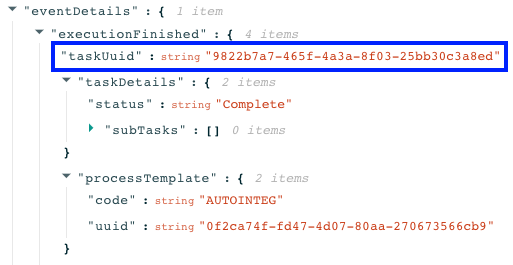

In [ ]:
#@title <font color='lime'> Run Webhook dashboard <font>

from IPython.display import IFrame

IFrame(src='https://play.svix.com/view/e_wdUPMbdZ1RpJnt0FaltbHlqxXCI/', width=1000, height=600)

## <font color='yellow'> Steps 3-4: Extract a list of accounts from the log of AUTOINTEG</font>

Taking the taskUuid from the previous step, details of AUTOINTEG execution can be requested and further parsed to retrieve the updated accounts and check the number of integrated transactions.<br>
API request: `/v1/process-templates/:taskUuid/details`<br>

These steps cannot be completely replicated within the Kyriba API Playground for this sample. The AUTOINTEG process is always executed on behalf of one user (e.g. USER1) selected in the application. Another user (e.g. USER2) does not have permission to access details of the task executed by USER1.<br>

Below is the example of the details.

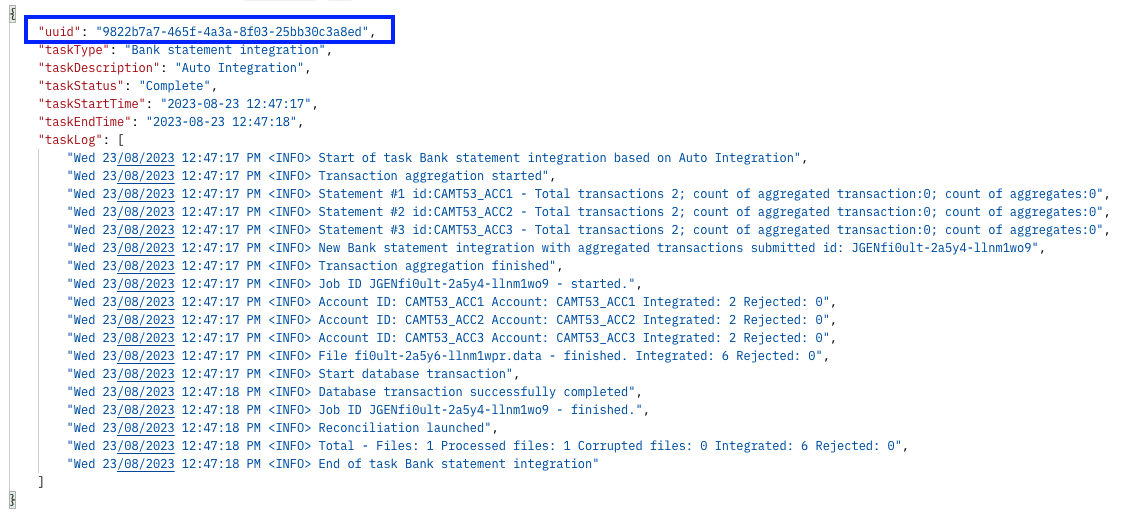